# Simplification of WDPA to be used in AOI
Because the original WDPA layers are too heavy to be displayed, we create 3 simplified layers that will be used in different zoom levels:

1. Detailed view: this will use the most simplified version, one in which some geometries can be removed
2. Medium zoom levels: for this we will keep all geometries but simplify the geometries as much as possible
3. Global zoom: for this we need a slightly simplified layer that preserves the shapes as much as possible and keeps all the geometries (except those that have null geometries). This layer will be heavier and only displayed at very detailed zooms.

The 3 simplifications will be made using mapshaper. We will base the simplification in the command used in Marxan, but testing different options to find the most efficient way to display each of these 3 layers.

> Mapshaper commad used in Marxan:
`!mapshaper -i /Users/tamarahuete/Documents/HALF_EARTH/Ecoregions2017_20210825.shp snap combine-files \
        -simplify 25% planar keep-shapes \
        -filter-islands min-vertices=3 min-area=10000m2 remove-empty \
        -filter-slivers min-area=10000m2 remove-empty \
        -clean rewind \
        -o /Users/tamarahuete/Documents/HALF_EARTH/Ecoregions2017_20210825_simple.shp format=shapefile force ndjson`

In [ ]:
# ## In terminal run to install mapshaper:
# !nvm use 12.21.0
# !npm i -g mapshaper@0.5.67

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
from zipfile import ZipFile

## Terrestrial WDPAs

In [2]:
path = '/Users/sofia/Documents/HE_Data/WDPA'

In [ ]:
# Original layer with only terrestrial (no marine) used for the AOI precalculated data.
gdf = gpd.read_file(f'{path}/WDPA_FILTERED_20210615_FILTERED_nomarine_with_oecm_wdpa/WDPA_FILTERED_20210615_FILTERED_nomarine_with_oecm_wdpa.shp')

# Repair geometries, in case some are invalid, and check how many are valid
gdf['geometry'] = gdf['geometry'].buffer(0) # this is to repair geometries
sum(gdf.is_valid) # 217429 geometries valid so only 57 invalid

# Remove invalid geometries
gdf2 = gdf[gdf['geometry'].is_valid]
gdf2.to_file('/Users/sofia/Documents/HE_Data/WDPA//WDPA_FILTERED_20210615_nomarine_wdpa_corrected_geometries/WDPA_FILTERED_20210615_nomarine_corrected_geometries.shp', driver= 'ESRI Shapefile')

In [6]:
# Read file with terrestrial WDPA (corrected)
gdf = gpd.read_file(f'{path}/WDPA_FILTERED_20210615_nomarine_wdpa_corrected_geometries/WDPA_FILTERED_20210615_nomarine_corrected_geometries.shp')
len(gdf)

217429

In [6]:
gdf[gdf['WDPA_PID']=='394131'] # csv keeps original characters as they are

,WDPAID,WDPA_PID,PA_DEF,NAME,ORIG_NA,DESIG,DESIG_E,DESIG_T,IUCN_CA,INT_CRI,...,ISO3,SUPP_IN,CONS_OB,SORTER,WDPA_PID_h,WDPA_PID__,hash_vl,AREA_KM,MOL_ID,geometry
177470,394131.0,394131,1,"""Fonds Gatot"" Et ""Laid Mâle""","""Fonds Gatot"" Et ""Laid Mâle""",Site Naturel D'Interêt Scientifique,Scientific Interest Site (Walloon Region),National,IV,Not Applicable,...,BEL,Not Applicable,Not Applicable,0.0,737c7794,-1628145044,-1628145044,0.100151,177471,"MULTIPOLYGON (((4.76386 50.58017, 4.76390 50.5..."


In [7]:
gdf[gdf['NAME'].str.contains('Bácsalmási')] # still, there are some names messed up in the original layer (probably due to previous manipulations)

,WDPAID,WDPA_PID,PA_DEF,NAME,ORIG_NA,DESIG,DESIG_E,DESIG_T,IUCN_CA,INT_CRI,...,ISO3,SUPP_IN,CONS_OB,SORTER,WDPA_PID_h,WDPA_PID__,hash_vl,AREA_KM,MOL_ID,geometry
90695,178339.0,178339,1,Bácsalmási Gyapjas Gy?sz?virág Term?helye Term...,Bácsalmási Gyapjas Gy?sz?virág Term?helye Term...,Természetvédelmi Terület,Nature Conservation Area,National,IV,Not Applicable,...,HUN,Not Applicable,Not Applicable,0.0,4a2e7c4e,1087259493,1087259493,0.038925,90696,"POLYGON ((19.33125 46.09428, 19.33171 46.09425..."


Let's solve the names issue before proceeding to the simplifications using the names collected in this [WDPA dataset](https://eowilson.maps.arcgis.com/home/item.html?id=ef9262a20fbb41bc8dc5eefdc9b93691)

In [4]:
wdpa_names = pd.read_csv('/Users/sofia/Documents/HE_Data/WDPA/WDPA_FILTERED_20210615_FILTERED_TERR01_missing1980_no_oecm_wdpa_pid_hash_20230322.csv')

In [9]:
wdpa_names[wdpa_names.NAME.str.contains('Bácsalmási')] # The NAME here is correct

,WDPAID,WDPA_PID,PA_DEF,NAME,ORIG_NAME,DESIG,DESIG_ENG,DESIG_TYPE,IUCN_CAT,INT_CRIT,...,METADATAID,SUB_LOC,PARENT_ISO3,ISO3,SUPP_INFO,CONS_OBJ,SORTER,WDPA_PID_hash,WDPA_PID_hash_int,hash_value
90643,178339,178339,1,Bácsalmási Gyapjas Gyűszűvirág Termőhelye Term...,Bácsalmási Gyapjas Gyűszűvirág Termőhelye Term...,Természetvédelmi Terület,Nature Conservation Area,National,IV,Not Applicable,...,1839,Not Reported,HUN,HUN,Not Applicable,Not Applicable,1992.16,4a2e7c4e,1087259493,1087259493


In [13]:
names = wdpa_names[['WDPA_PID','ORIG_NAME', 'NAME', 'DESIG', 'DESIG_ENG']].rename(columns={'NAME':'NAME_correct','DESIG':'DESIG_correct'})
names.head(1)

,WDPA_PID,ORIG_NAME,NAME_correct,DESIG_correct,DESIG_ENG
0,555561621,"Lsg-Morsbachtal, Eschbachtal, Seitentaeler Und...","Lsg-Morsbachtal, Eschbachtal, Seitentaeler Und...",Landschaftschutzgebiet,Landscape Protection Area


In [14]:
# Merge NAME columns from new dataset into the old one
dff = pd.merge(gdf, names, how='left', on='WDPA_PID')
dff.head(1)

,WDPAID,WDPA_PID,PA_DEF,NAME,ORIG_NA,DESIG,DESIG_E,DESIG_T,IUCN_CA,INT_CRI,...,WDPA_PID_h,WDPA_PID__,hash_vl,AREA_KM,MOL_ID,geometry,ORIG_NAME,NAME_correct,DESIG_correct,DESIG_ENG
0,310492.0,310492,1,Boulder Beach,Boulder Beach / WWF Block,Stewardship Area,Stewardship Area,National,III,Not Applicable,...,9cb933d7,1802338827,1802338827,1.136031,1,"MULTIPOLYGON (((170.62746 -45.89520, 170.62824...",Boulder Beach / WWF Block,Boulder Beach,Stewardship Area,Stewardship Area


In [8]:
# Check which wdpa have different names in the first dataset compared to the corrected dataset
dff2 = dff[dff.NAME!=dff.NAME_correct]
dff2[['NAME', 'NAME_correct']]

,NAME,NAME_correct
20,"Mt Cargill ""Scenic Reserve""","Mt Cargill """"Scenic Reserve"""""
1270,Hima Huraymila? National Park,Hima Huraymila’ National Park
1271,Al-Ha?ir Wetland,Al-Ha’ir Wetland
1272,Yanbu? Coastal Conservation Area,Yanbu‘ Coastal Conservation Area
2692,ORI VARNOUNTA ? EVRYTERI PERIOCHI,ORI VARNOUNTA – EVRYTERI PERIOCHI
...,...,...
217424,4.11 St Sampson's Marais / Ivy Castle,NaN
217425,4.7 Les Vicheries and Rue Rocheuse,NaN
217426,"Les Demoiselles nursery (Plaisance Bay), Magda...",NaN
217427,Strait Of Georgia And Howe Sound Glass Sponge ...,NaN


In [15]:
# Give to each wdpa with NaN values in the corrected dataset the name they have in the original one
dff.NAME_correct.fillna(dff.NAME, inplace=True)
dff.ORIG_NAME.fillna(dff.ORIG_NA, inplace=True)
dff.DESIG_correct.fillna(dff.DESIG, inplace=True)
dff.DESIG_ENG.fillna(dff.DESIG_E, inplace=True)

In [10]:
# Check again which wdpa have different names in the first dataset compared to the corrected dataset
dff2 = dff[dff.NAME!=dff.NAME_correct]
dff2[['NAME', 'NAME_correct']]

,NAME,NAME_correct
20,"Mt Cargill ""Scenic Reserve""","Mt Cargill """"Scenic Reserve"""""
1270,Hima Huraymila? National Park,Hima Huraymila’ National Park
1271,Al-Ha?ir Wetland,Al-Ha’ir Wetland
1272,Yanbu? Coastal Conservation Area,Yanbu‘ Coastal Conservation Area
2692,ORI VARNOUNTA ? EVRYTERI PERIOCHI,ORI VARNOUNTA – EVRYTERI PERIOCHI
...,...,...
216257,Complexe du Parc Urbain Bãngr ? Weoogo et du l...,Complexe du Parc Urbain Bãngr – Weoogo et du l...
216635,Ch?ihilii Chìk,Ch’ihilii Chìk
216687,5-10-77,5/10/1977
216782,"Centr ohrany prirody ""Zejskij""","Centr ohrany prirody """"Zejskij"""""


In [16]:
# Give to NAME in original dataset the new names
dff.NAME = dff.NAME_correct
dff = dff.drop(columns={'NAME_correct'})
dff.ORIG_NA = dff.ORIG_NAME
dff = dff.drop(columns={'ORIG_NAME'})
dff.DESIG = dff.DESIG_correct
dff = dff.drop(columns={'DESIG_correct'})
dff.DESIG_E = dff.DESIG_ENG
dff = dff.drop(columns={'DESIG_ENG'})
dff.head()

,WDPAID,WDPA_PID,PA_DEF,NAME,ORIG_NA,DESIG,DESIG_E,DESIG_T,IUCN_CA,INT_CRI,...,ISO3,SUPP_IN,CONS_OB,SORTER,WDPA_PID_h,WDPA_PID__,hash_vl,AREA_KM,MOL_ID,geometry
0,310492.0,310492,1,Boulder Beach,Boulder Beach / WWF Block,Stewardship Area,Stewardship Area,National,III,Not Applicable,...,NZL,Not Applicable,Not Applicable,0.0,9cb933d7,1802338827,1802338827,1.136031,1,"MULTIPOLYGON (((170.62746 -45.89520, 170.62824..."
1,307797.0,307797,1,Ferndale,Ferndale,Scenic Reserve,Scenic Reserve,National,III,Not Applicable,...,NZL,Not Applicable,Not Applicable,0.0,6dcdc88b,781004482,781004482,0.748492,2,"POLYGON ((173.97642 -41.19258, 173.97595 -41.1..."
2,307745.0,307745,1,Broughton Bay,Broughton Bay,Scenic Reserve,Scenic Reserve,National,III,Not Applicable,...,NZL,Not Applicable,Not Applicable,0.0,322a981f,-1455988893,-1455988893,0.031907,3,"POLYGON ((173.95691 -41.20976, 173.95580 -41.2..."
3,307867.0,307867,1,Kaipupu Point,Kaipupu Point,Scenic Reserve,Scenic Reserve,National,III,Not Applicable,...,NZL,Not Applicable,Not Applicable,0.0,dc69e4d7,1645593535,1645593535,0.270855,4,"POLYGON ((174.00241 -41.27336, 174.00312 -41.2..."
4,303963.0,303963,1,Catlins Conservation Park,Catlins Conservation Park,Stewardship Area,Stewardship Area,National,III,Not Applicable,...,NZL,Not Applicable,Not Applicable,0.0,ff0048d0,1218801077,1218801077,8.412168,5,"MULTIPOLYGON (((169.53396 -46.44102, 169.53387..."


In [17]:
dff[dff.NAME.str.contains('Bácsalmási')] # Now the NAME here is correct

,WDPAID,WDPA_PID,PA_DEF,NAME,ORIG_NA,DESIG,DESIG_E,DESIG_T,IUCN_CA,INT_CRI,...,ISO3,SUPP_IN,CONS_OB,SORTER,WDPA_PID_h,WDPA_PID__,hash_vl,AREA_KM,MOL_ID,geometry
90695,178339.0,178339,1,Bácsalmási Gyapjas Gyűszűvirág Termőhelye Term...,Bácsalmási Gyapjas Gyűszűvirág Termőhelye Term...,Természetvédelmi Terület,Nature Conservation Area,National,IV,Not Applicable,...,HUN,Not Applicable,Not Applicable,0.0,4a2e7c4e,1087259493,1087259493,0.038925,90696,"POLYGON ((19.33125 46.09428, 19.33171 46.09425..."


In [18]:
len(dff)

217429

<AxesSubplot:>

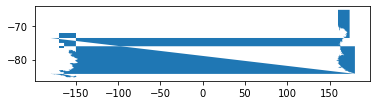

In [20]:
dff[dff.WDPA_PID=='555624810_A'].plot()

In [21]:
dff_new = dff.loc[dff['WDPA_PID'] != '555624810_A']

Converting the shp to json (for the simplification) changes the original characters of the names, so let's create a new gdf that only contains geometries and the MOL_ID of the WDPA and use it for the simplification. Then we'll join the required attributes from the original table to the resulting simplificated layer. 

In [22]:
gdf2 = dff_new[['MOL_ID','geometry']]

In [23]:
%%time
# Save file in local
gdf2.to_file(f'{path}/WDPA_Terrestrial_corrected_geomOnly', driver= 'ESRI Shapefile')

CPU times: user 5min 43s, sys: 16.2 s, total: 5min 59s
Wall time: 6min 16s


### Simplifications

#### 1. Low simplification (to be used at large scales with a greater amount of detail)

In [24]:
# Break the shp into 12 json files to make the process more efficient
!mapshaper-xl 16gb -i ./../../HE_Data/WDPA/WDPA_Terrestrial_corrected_geomOnly/*.shp no-topology combine-files \
    -merge-layers \
    -each "group = Math.trunc(this.id/20000)+1" \
    -split group \
    -o WDPA_test/ format=geojson precision=0.0001 force ndjson

Allocating 16 GB of heap memory
[merge-layers] Use the target= option to specify multiple layers for merging
[o] Wrote WDPA_test/1.json
[o] Wrote WDPA_test/2.json
[o] Wrote WDPA_test/3.json
[o] Wrote WDPA_test/4.json
[o] Wrote WDPA_test/5.json
[o] Wrote WDPA_test/6.json
[o] Wrote WDPA_test/7.json
[o] Wrote WDPA_test/8.json
[o] Wrote WDPA_test/9.json
[o] Wrote WDPA_test/10.json
[o] Wrote WDPA_test/11.json


In [25]:
%%time
# Only simplify (retains all geometries).
!mapshaper-xl 16gb -i ./WDPA_test/*.json snap \
    -simplify 50% weighting=0.3 planar keep-shapes \
    -o WDPA_test/ format=geojson force ndjson

Allocating 16 GB of heap memory
[i] Snapped 0 points
[simplify] Repaired 5,032 intersections; 9,944 intersections could not be repaired
[o] Wrote WDPA_test/1.json
[i] Snapped 0 points
[simplify] Repaired 6,826 intersections; 32,382 intersections could not be repaired
[o] Wrote WDPA_test/10.json
[i] Snapped 0 points
[simplify] Repaired 0 intersections; 49,343 intersections could not be repaired
[o] Wrote WDPA_test/11.json
[i] Snapped 0 points
[simplify] Repaired 2,478 intersections; 16,006 intersections could not be repaired
[o] Wrote WDPA_test/2.json
[i] Snapped 0 points
[simplify] Repaired 2,590 intersections; 33,808 intersections could not be repaired
[o] Wrote WDPA_test/3.json
[i] Snapped 0 points
[simplify] Repaired 2,073 intersections; 14,770 intersections could not be repaired
[o] Wrote WDPA_test/4.json
[i] Snapped 0 points
[simplify] Repaired 1,564 intersections; 24,268 intersections could not be repaired
[o] Wrote WDPA_test/5.json
[i] Snapped 0 points
[simplify] Repaired 527 in

In [27]:
# Combine all json files in a shp. 
!mapshaper-xl 16gb -i ./WDPA_test/*.json combine-files -merge-layers -info -o WDPA_test/wdpa_simp1.shp

Allocating 16 GB of heap memory
[info] 
Layer:    [unnamed layer]
-------------------------
Type:     polygon
Records:  217,428
Nulls:     444
Bounds:   -179.9999,-69.4778,179.9999,83.73
CRS:      +proj=longlat +datum=WGS84
Source:   ./WDPA_test/1.json

Attribute data
--------+-------------
 Field  | First value
--------+-------------
 group  | 1
 MOL_ID | 1
--------+-------------

[o] Wrote WDPA_test/wdpa_simp1.shp
[o] Wrote WDPA_test/wdpa_simp1.shx
[o] Wrote WDPA_test/wdpa_simp1.dbf
[o] Wrote WDPA_test/wdpa_simp1.prj


In [47]:
sim1 = gpd.read_file('WDPA_test/wdpa_simp1.shp') # len 217429, retains all geometries
len(sim1)

217428

In [48]:
## Set crs
sim1 = sim1.set_crs('EPSG:4326') 

In [49]:
%%time
# Repair geometries, in case some are invalid after simplification, and check how many are valid
sim1['geometry'] = sim1['geometry'].buffer(0) # this is to repair geometries
sum(sim1.is_valid) # now 216983 geometries valid so there are still 446 invalid

CPU times: user 44min 11s, sys: 1min 3s, total: 45min 15s
Wall time: 45min 57s


216982

In [50]:
# Remove invalid geometries
valid = sim1[sim1['geometry'].is_valid]
len(valid)

216982

In [52]:
# Let's check which are the invalid geometries 
list1 = list(valid['MOL_ID'].unique())
list2 = list(sim1['MOL_ID'].unique())
invalid = list(set(list2).difference(list1)) 
len(invalid)

446

In [53]:
invalid[0]

116736

In [54]:
# Remove these invalid geometries from sim1 
sim1_valid = sim1[~sim1['MOL_ID'].isin(invalid)]
sim1_valid = sim1_valid[['MOL_ID', 'geometry']]
sim1_valid.head(1)

,MOL_ID,geometry
0,1,"MULTIPOLYGON (((170.62750 -45.89520, 170.62820..."


In [55]:
# Get geometries that were invalid in sim1 from original layer
geom = gdf2[gdf2['MOL_ID'].isin(invalid)]
len(geom)

446

In [56]:
# Add valid geometries to sim1
sim1 = pd.concat([sim1_valid, geom])
len(sim1)

217428

In [38]:
dff.head(1)

,WDPAID,WDPA_PID,PA_DEF,NAME,ORIG_NA,DESIG,DESIG_E,DESIG_T,IUCN_CA,INT_CRI,...,ISO3,SUPP_IN,CONS_OB,SORTER,WDPA_PID_h,WDPA_PID__,hash_vl,AREA_KM,MOL_ID,geometry
0,310492.0,310492,1,Boulder Beach,Boulder Beach / WWF Block,Stewardship Area,Stewardship Area,National,III,Not Applicable,...,NZL,Not Applicable,Not Applicable,0.0,9cb933d7,1802338827,1802338827,1.136031,1,"MULTIPOLYGON (((170.62746 -45.89520, 170.62824..."


In [39]:
sim1.head()

,MOL_ID,geometry
0,1,"MULTIPOLYGON (((170.62750 -45.89520, 170.62820..."
1,2,"POLYGON ((173.97640 -41.19260, 173.97350 -41.1..."
2,3,"POLYGON ((173.95690 -41.20980, 173.95510 -41.2..."
3,4,"POLYGON ((174.00240 -41.27340, 174.00340 -41.2..."
4,5,"MULTIPOLYGON (((169.53390 -46.44740, 169.53270..."


In [57]:
# Remove geometries from original file containing info about WDPA
gdf_no_geom = dff.drop(columns='geometry')
gdf_no_geom.head(1)

,WDPAID,WDPA_PID,PA_DEF,NAME,ORIG_NA,DESIG,DESIG_E,DESIG_T,IUCN_CA,INT_CRI,...,PARENT_,ISO3,SUPP_IN,CONS_OB,SORTER,WDPA_PID_h,WDPA_PID__,hash_vl,AREA_KM,MOL_ID
0,310492.0,310492,1,Boulder Beach,Boulder Beach / WWF Block,Stewardship Area,Stewardship Area,National,III,Not Applicable,...,NZL,NZL,Not Applicable,Not Applicable,0.0,9cb933d7,1802338827,1802338827,1.136031,1


In [58]:
# Merge dataframe with only attributes (no geometry) with gdf containing simplified geometries
sim1 = gpd.GeoDataFrame(pd.merge(sim1, gdf_no_geom,  how='left', left_on=['MOL_ID'], right_on = ['MOL_ID']))
sim1.head(1)

,MOL_ID,geometry,WDPAID,WDPA_PID,PA_DEF,NAME,ORIG_NA,DESIG,DESIG_E,DESIG_T,...,SUB_LOC,PARENT_,ISO3,SUPP_IN,CONS_OB,SORTER,WDPA_PID_h,WDPA_PID__,hash_vl,AREA_KM
0,1,"MULTIPOLYGON (((170.62750 -45.89520, 170.62820...",310492.0,310492,1,Boulder Beach,Boulder Beach / WWF Block,Stewardship Area,Stewardship Area,National,...,NZ-OTA,NZL,NZL,Not Applicable,Not Applicable,0.0,9cb933d7,1802338827,1802338827,1.136031


In [59]:
sim1[sim1.NAME.str.contains('U Kapli')]

,MOL_ID,geometry,WDPAID,WDPA_PID,PA_DEF,NAME,ORIG_NA,DESIG,DESIG_E,DESIG_T,...,SUB_LOC,PARENT_,ISO3,SUPP_IN,CONS_OB,SORTER,WDPA_PID_h,WDPA_PID__,hash_vl,AREA_KM
158849,121629,"POLYGON ((16.26520 48.95540, 16.26530 48.95620...",344388.0,344388,1,U Kapličky,U Kapličky,Přírodní Památka (Pp),Nature Monument,National,...,Not Reported,CZE,CZE,Not Applicable,Not Applicable,0.0,81f98493,-1095149455,-1095149455,0.050354


In [60]:
# Select only relevant attributes
sim1 = sim1.rename(columns={'AREA_KM':'AREA_KM2'})
sim1 = sim1[['MOL_ID', 'geometry', 'WDPAID', 'WDPA_PID', 'NAME', 'ORIG_NA', 'DESIG', 'DESIG_T', 'DESIG_E',
       'IUCN_CA', 'STATUS', 'STATUS_', 'GOV_TYP', 'MANG_AU', 'ISO3', 'AREA_KM2']] 
sim1.columns

Index(['MOL_ID', 'geometry', 'WDPAID', 'WDPA_PID', 'NAME', 'ORIG_NA', 'DESIG',
       'DESIG_T', 'DESIG_E', 'IUCN_CA', 'STATUS', 'STATUS_', 'GOV_TYP',
       'MANG_AU', 'ISO3', 'AREA_KM2'],
      dtype='object')

In [61]:
sim1[sim1.NAME.str.contains('U Kapli')]

,MOL_ID,geometry,WDPAID,WDPA_PID,NAME,ORIG_NA,DESIG,DESIG_T,DESIG_E,IUCN_CA,STATUS,STATUS_,GOV_TYP,MANG_AU,ISO3,AREA_KM2
158849,121629,"POLYGON ((16.26520 48.95540, 16.26530 48.95620...",344388.0,344388,U Kapličky,U Kapličky,Přírodní Památka (Pp),National,Nature Monument,IV,Designated,2001.0,Federal or national ministry or agency,Not Reported,CZE,0.050354


In [40]:
dff[dff['MOL_ID']==14318]

,WDPAID,WDPA_PID,PA_DEF,NAME,ORIG_NA,DESIG,DESIG_E,DESIG_T,IUCN_CA,INT_CRI,...,ISO3,SUPP_IN,CONS_OB,SORTER,WDPA_PID_h,WDPA_PID__,hash_vl,AREA_KM,MOL_ID,geometry
14317,55558010.0,55558010,1,Quinnipiac River,Quinnipiac River,State Park,State Park,National,III,Not Applicable,...,USA,Not Applicable,Not Applicable,0.0,69578420,-2072596068,-2072596068,1.407164,14318,"MULTIPOLYGON (((-72.83994 41.44611, -72.84000 ..."


<AxesSubplot:>

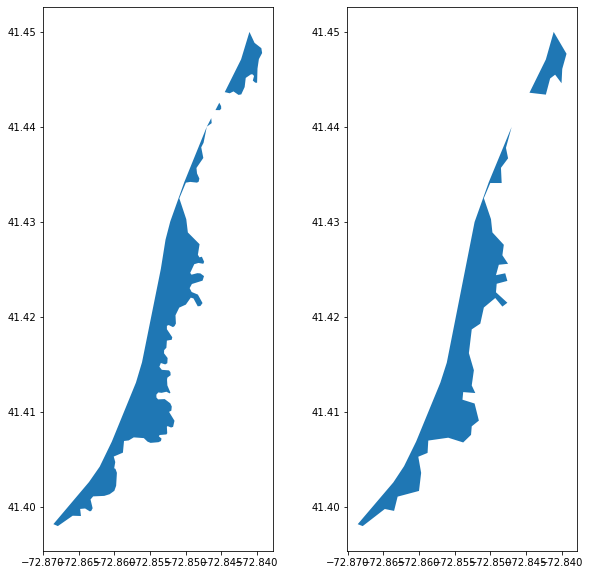

In [44]:
# Compare geometries in original and simplified dataset
n= 14318
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
dff[dff['MOL_ID']==n].geometry.plot(ax = ax1) 
sim1[sim1['MOL_ID']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

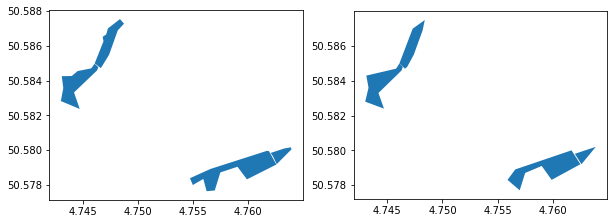

In [42]:
# Compare geometries in original and simplified dataset
n= '394131'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
dff[dff['WDPA_PID']==n].geometry.plot(ax = ax1) 
sim1[sim1['WDPA_PID']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

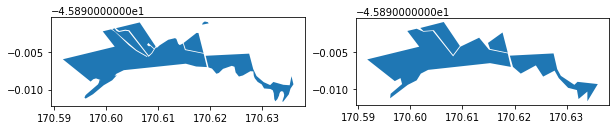

In [43]:
n= '310492'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
dff[dff['WDPA_PID']==n].geometry.plot(ax = ax1) 
sim1[sim1['WDPA_PID']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

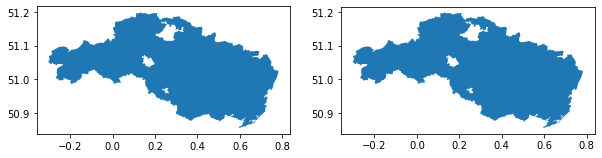

In [62]:
n = '20609'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
dff[dff['WDPA_PID']==n].geometry.plot(ax = ax1) 
sim1[sim1['WDPA_PID']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

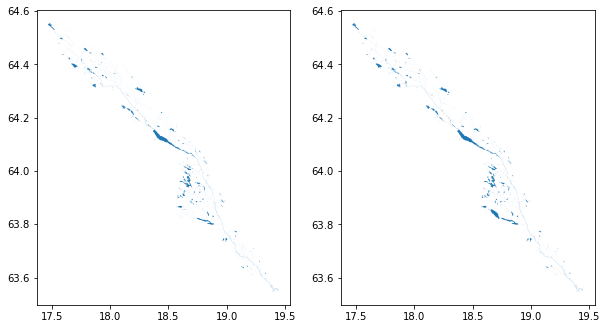

In [45]:
n = '555534655'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
dff[dff['WDPA_PID']==n].geometry.plot(ax = ax1) 
sim1[sim1['WDPA_PID']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

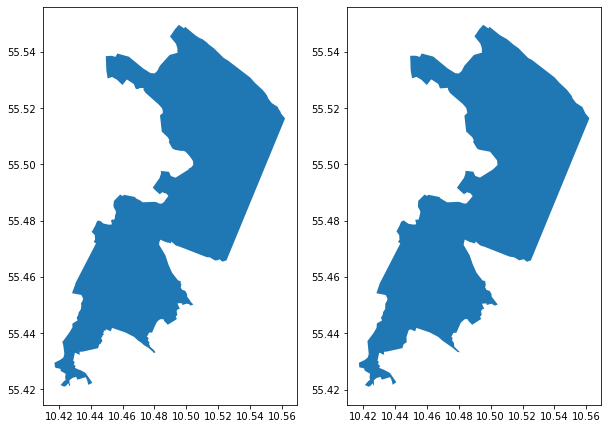

In [63]:
n = '555703244'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
dff[dff['WDPA_PID']==n].geometry.plot(ax = ax1) 
sim1[sim1['WDPA_PID']==n].geometry.plot(ax = ax2)

In [64]:
sim1.columns

Index(['MOL_ID', 'geometry', 'WDPAID', 'WDPA_PID', 'NAME', 'ORIG_NA', 'DESIG',
       'DESIG_T', 'DESIG_E', 'IUCN_CA', 'STATUS', 'STATUS_', 'GOV_TYP',
       'MANG_AU', 'ISO3', 'AREA_KM2'],
      dtype='object')

In [45]:
# Add extra info from precalculated table needed for tooltips
agol = pd.read_csv('/Users/sofia/Documents/HE_Data/Precalculated/WDPA_Precalculated/Outputs/wdpa_precalculated_aoi_summaries.csv')

/opt/anaconda3/envs/vizz38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1,15,20,22,23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [50]:
agol.columns

Index(['Unnamed: 0', 'MOL_ID', 'WDPAID', 'WDPA_PID', 'NAME', 'DESIG',
       'DESIG_T', 'IUCN_CA', 'STATUS', 'GOV_TYP', 'MANG_AU', 'ISO3',
       'AREA_KM2', 'DESIG_E', 'ORIG_NA', 'STATUS_', 'amphibians', 'birds',
       'mammals', 'reptiles', 'amph_nspecies', 'bird_nspecies',
       'mamm_nspecies', 'rept_nspecies', 'nspecies',
       'majority_land_cover_climate_regime', 'land_cover_majority',
       'climate_regime_majority', 'population_sum', 'agriculture', 'builtup',
       'extraction', 'intrusion', 'transportation'],
      dtype='object')

In [65]:
agol2 = agol[['MOL_ID', 'nspecies']]
agol2.head(1)

,MOL_ID,nspecies
0,1,52.0


In [66]:
# Merge new attributes
sim1 = gpd.GeoDataFrame(pd.merge(sim1, agol2,  how='left', left_on=['MOL_ID'], right_on = ['MOL_ID']))
sim1.head(1)

,MOL_ID,geometry,WDPAID,WDPA_PID,NAME,ORIG_NA,DESIG,DESIG_T,DESIG_E,IUCN_CA,STATUS,STATUS_,GOV_TYP,MANG_AU,ISO3,AREA_KM2,nspecies
0,1,"MULTIPOLYGON (((170.62750 -45.89520, 170.62820...",310492.0,310492,Boulder Beach,Boulder Beach / WWF Block,Stewardship Area,National,Stewardship Area,III,Designated,NaN,Federal or national ministry or agency,Department of Conservation,NZL,1.136031,52.0


In [67]:
sim1.columns

Index(['MOL_ID', 'geometry', 'WDPAID', 'WDPA_PID', 'NAME', 'ORIG_NA', 'DESIG',
       'DESIG_T', 'DESIG_E', 'IUCN_CA', 'STATUS', 'STATUS_', 'GOV_TYP',
       'MANG_AU', 'ISO3', 'AREA_KM2', 'nspecies'],
      dtype='object')

In [68]:
# Save file in local
sim1.to_file(f'{path}/Simplifications/WDPA_Ter_Simp50_nspecies.geojson', driver= 'GeoJSON')

<AxesSubplot:>

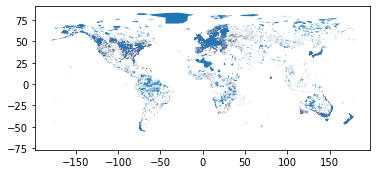

In [69]:
sim1.plot()

In [70]:
len(sim1)

217428

#### 2. Mid simplification (to be used at medium scales with a medium amount of detail)

In [94]:
# Break the shp into 12 json files to make the process more efficient
!mapshaper-xl 16gb -i ./../../HE_Data/WDPA/WDPA_Terrestrial_corrected_geomOnly/*.shp no-topology combine-files \
    -merge-layers \
    -each "group = Math.trunc(this.id/20000)+1" \
    -split group \
    -o WDPA_test/ format=geojson precision=0.0001 force ndjson

Allocating 16 GB of heap memory
[merge-layers] Use the target= option to specify multiple layers for merging
[o] Wrote WDPA_test/1.json
[o] Wrote WDPA_test/2.json
[o] Wrote WDPA_test/3.json
[o] Wrote WDPA_test/4.json
[o] Wrote WDPA_test/5.json
[o] Wrote WDPA_test/6.json
[o] Wrote WDPA_test/7.json
[o] Wrote WDPA_test/8.json
[o] Wrote WDPA_test/9.json
[o] Wrote WDPA_test/10.json
[o] Wrote WDPA_test/11.json


In [95]:
%%time
# Only simplify (removes some geometries).
!mapshaper-xl 16gb -i ./WDPA_test/*.json snap \
    -simplify 10% weighting=0.3 planar keep-shapes \
    -filter-islands min-vertices=3 min-area=10000m2 remove-empty \
    -filter-slivers min-area=10000m2 remove-empty \
    -clean rewind \
    -o WDPA_test/ format=geojson force ndjson

Allocating 16 GB of heap memory
[i] Snapped 0 points
[simplify] Repaired 4,892 intersections; 3,221 intersections could not be repaired
[filter-islands] Removed 43,266 islands
[filter-slivers] Removed 11,485 slivers using 0.01+ sqkm variable threshold
[clean] Removed 698 / 2,038 slivers using 0.17+ sqkm variable threshold
[clean] Retained 16,728 of 18,433 features
[o] Wrote WDPA_test/1.json
[i] Snapped 0 points
[simplify] Repaired 6,289 intersections; 13,012 intersections could not be repaired
[filter-islands] Removed 37,145 islands
[filter-slivers] Removed 10,201 slivers using 0.01+ sqkm variable threshold
[clean] Removed 1,699 / 2,659 slivers using 0.12+ sqkm variable threshold
[clean] Retained 16,348 of 18,496 features
[o] Wrote WDPA_test/10.json
[i] Snapped 0 points
[simplify] Repaired 8,179 intersections; 11,164 intersections could not be repaired
[filter-islands] Removed 65,358 islands
[filter-slivers] Removed 31,780 slivers using 0.01+ sqkm variable threshold
[clean] Removed 3,6

In [96]:
# Combine all json files in a shp.
!mapshaper-xl 16gb -i ./WDPA_test/*.json combine-files -merge-layers -info -o WDPA_test/wdpa_simp2.shp

Allocating 16 GB of heap memory
[info] 
Layer:    [unnamed layer]
-------------------------
Type:     polygon
Records:  175,179
Bounds:   -180,-85.4119,180,83.73
CRS:      +proj=longlat +datum=WGS84
Source:   ./WDPA_test/1.json

Attribute data
--------+-------------
 Field  | First value
--------+-------------
 group  | 1
 MOL_ID | 1
--------+-------------

[o] Wrote WDPA_test/wdpa_simp2.shp
[o] Wrote WDPA_test/wdpa_simp2.shx
[o] Wrote WDPA_test/wdpa_simp2.dbf
[o] Wrote WDPA_test/wdpa_simp2.prj


In [97]:
%%time
sim2 = gpd.read_file('WDPA_test/wdpa_simp2.shp') 
len(sim2)

CPU times: user 10.1 s, sys: 2.87 s, total: 12.9 s
Wall time: 15 s


175179

In [98]:
len(dff)-len(sim2) # 40,705 geometries removed in this simplification

42250

In [99]:
## Set crs
sim2 = sim2.set_crs('EPSG:4326') 

In [100]:
%%time
# Repair geometries, in case some are invalid after simplification, and check how many are valid
sim2['geometry'] = sim2['geometry'].buffer(0) # this is to repair geometries
sum(sim2.is_valid) # the same after simplification - all valid

CPU times: user 4min 39s, sys: 2.52 s, total: 4min 42s
Wall time: 4min 45s


175179

In [101]:
sim2 = sim2.drop(columns={'group'})
sim2.head()

,MOL_ID,geometry
0,1,"POLYGON ((170.60250 -45.89230, 170.60820 -45.8..."
1,2,"POLYGON ((173.97640 -41.19260, 173.96920 -41.1..."
2,3,"POLYGON ((173.95690 -41.20980, 173.95510 -41.2..."
3,4,"POLYGON ((174.00240 -41.27340, 174.00880 -41.2..."
4,5,"MULTIPOLYGON (((169.53390 -46.44740, 169.52510..."


In [80]:
gdf_no_geom.head(1)

,WDPAID,WDPA_PID,PA_DEF,NAME,ORIG_NA,DESIG,DESIG_E,DESIG_T,IUCN_CA,INT_CRI,...,PARENT_,ISO3,SUPP_IN,CONS_OB,SORTER,WDPA_PID_h,WDPA_PID__,hash_vl,AREA_KM,MOL_ID
0,310492.0,310492,1,Boulder Beach,Boulder Beach / WWF Block,Stewardship Area,Stewardship Area,National,III,Not Applicable,...,NZL,NZL,Not Applicable,Not Applicable,0.0,9cb933d7,1802338827,1802338827,1.136031,1


In [102]:
sim2 = gpd.GeoDataFrame(pd.merge(sim2, gdf_no_geom,  how='left', left_on=['MOL_ID'], right_on = ['MOL_ID']))
sim2.head(1)

,MOL_ID,geometry,WDPAID,WDPA_PID,PA_DEF,NAME,ORIG_NA,DESIG,DESIG_E,DESIG_T,...,SUB_LOC,PARENT_,ISO3,SUPP_IN,CONS_OB,SORTER,WDPA_PID_h,WDPA_PID__,hash_vl,AREA_KM
0,1,"POLYGON ((170.60250 -45.89230, 170.60820 -45.8...",310492.0,310492,1,Boulder Beach,Boulder Beach / WWF Block,Stewardship Area,Stewardship Area,National,...,NZ-OTA,NZL,NZL,Not Applicable,Not Applicable,0.0,9cb933d7,1802338827,1802338827,1.136031


In [103]:
sim2 = sim2.rename(columns={'AREA_KM':'AREA_KM2'})
sim2.columns

Index(['MOL_ID', 'geometry', 'WDPAID', 'WDPA_PID', 'PA_DEF', 'NAME', 'ORIG_NA',
       'DESIG', 'DESIG_E', 'DESIG_T', 'IUCN_CA', 'INT_CRI', 'MARINE',
       'REP_M_A', 'GIS_M_A', 'REP_ARE', 'GIS_ARE', 'NO_TAKE', 'NO_TK_A',
       'STATUS', 'STATUS_', 'GOV_TYP', 'OWN_TYP', 'MANG_AU', 'MANG_PL',
       'VERIF', 'METADAT', 'SUB_LOC', 'PARENT_', 'ISO3', 'SUPP_IN', 'CONS_OB',
       'SORTER', 'WDPA_PID_h', 'WDPA_PID__', 'hash_vl', 'AREA_KM2'],
      dtype='object')

In [104]:
nspecies = agol2[['nspecies', 'MOL_ID']]

In [105]:
# Merge new attributes
sim2 = gpd.GeoDataFrame(pd.merge(sim2, nspecies, how='left', left_on=['MOL_ID'], right_on = ['MOL_ID']))
sim2.head(1)

,MOL_ID,geometry,WDPAID,WDPA_PID,PA_DEF,NAME,ORIG_NA,DESIG,DESIG_E,DESIG_T,...,PARENT_,ISO3,SUPP_IN,CONS_OB,SORTER,WDPA_PID_h,WDPA_PID__,hash_vl,AREA_KM2,nspecies
0,1,"POLYGON ((170.60250 -45.89230, 170.60820 -45.8...",310492.0,310492,1,Boulder Beach,Boulder Beach / WWF Block,Stewardship Area,Stewardship Area,National,...,NZL,NZL,Not Applicable,Not Applicable,0.0,9cb933d7,1802338827,1802338827,1.136031,52.0


In [20]:
dff[dff['MOL_ID']==14318]

,WDPAID,WDPA_PID,NAME,DESIG,DESIG_T,IUCN_CA,STATUS,GOV_TYP,MANG_AU,ISO3,AREA_KM,MOL_ID,geometry
14317,55558010.0,55558010,Quinnipiac River,State Park,National,III,Designated,Sub-national ministry or agency,Other or Unknown State Land ; State Department...,USA,1.411278,14318,"MULTIPOLYGON (((-72.84705 41.44000, -72.84750 ..."


<AxesSubplot:>

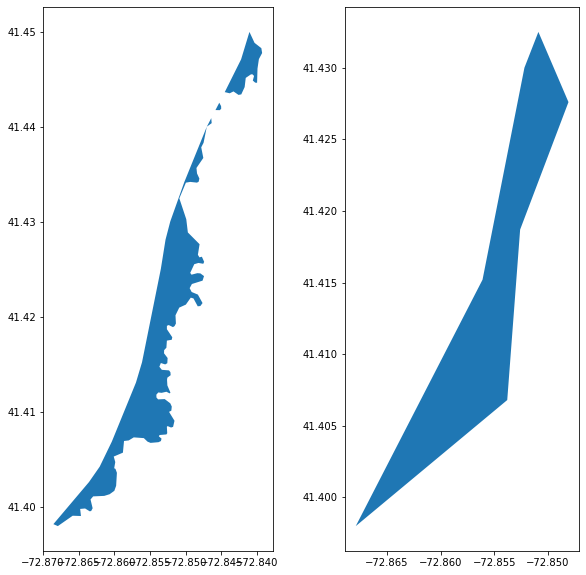

In [106]:
# Compare geometries in original and simplified dataset
n= 14318
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
dff[dff['MOL_ID']==n].geometry.plot(ax = ax1) 
sim2[sim2['MOL_ID']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

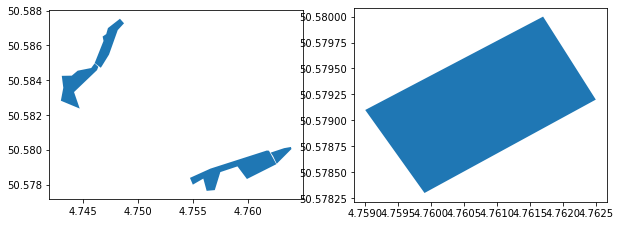

In [107]:
# Compare geometries in original and simplified dataset
n= '394131'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
dff[dff['WDPA_PID']==n].geometry.plot(ax = ax1) 
sim2[sim2['WDPA_PID']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

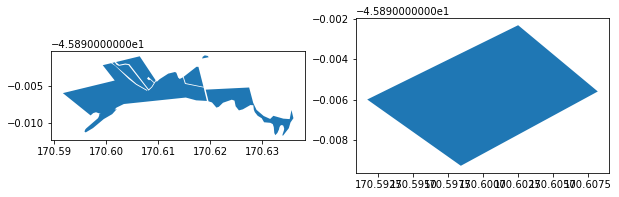

In [108]:
n= '310492'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
dff[dff['WDPA_PID']==n].geometry.plot(ax = ax1) 
sim2[sim2['WDPA_PID']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

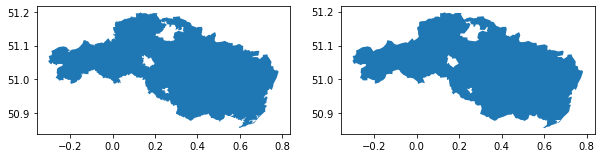

In [109]:
n = '20609'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
dff[dff['WDPA_PID']==n].geometry.plot(ax = ax1) 
sim2[sim2['WDPA_PID']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

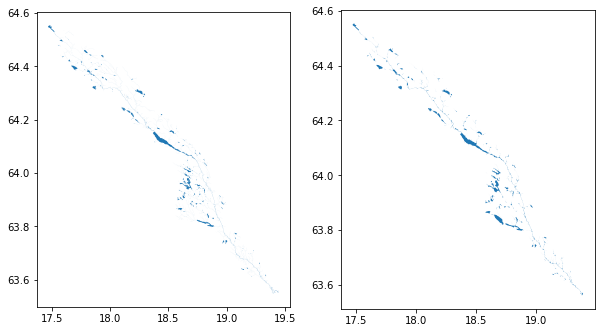

In [110]:
n = '555534655'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
dff[dff['WDPA_PID']==n].geometry.plot(ax = ax1) 
sim2[sim2['WDPA_PID']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

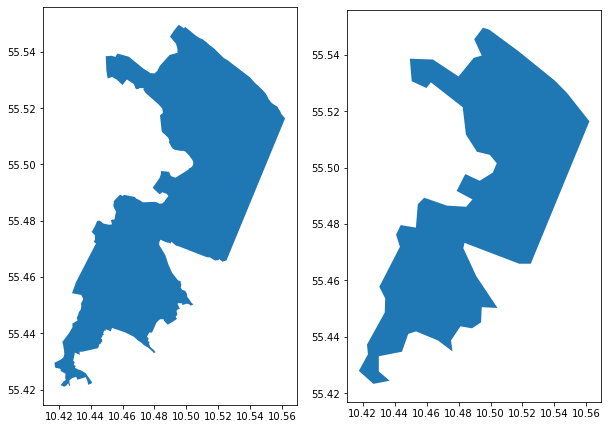

In [111]:
n = '555703244'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
dff[dff['WDPA_PID']==n].geometry.plot(ax = ax1) 
sim2[sim2['WDPA_PID']==n].geometry.plot(ax = ax2)

In [112]:
# Save file in local
sim2.to_file(f'{path}/Simplifications/WDPA_Ter_Simp90_nspecies.geojson', driver= 'GeoJSON')

#### 3. High simplification (to be used at global scale with very low detail)

In [113]:
# Break the shp into 12 json files to make the process more efficient
!mapshaper-xl 16gb -i ./../../HE_Data/WDPA/WDPA_Terrestrial_corrected_geomOnly/*.shp no-topology combine-files \
    -merge-layers \
    -each "group = Math.trunc(this.id/20000)+1" \
    -split group \
    -o WDPA_test/ format=geojson precision=0.0001 force ndjson

Allocating 16 GB of heap memory
[merge-layers] Use the target= option to specify multiple layers for merging
[o] Wrote WDPA_test/1.json
[o] Wrote WDPA_test/2.json
[o] Wrote WDPA_test/3.json
[o] Wrote WDPA_test/4.json
[o] Wrote WDPA_test/5.json
[o] Wrote WDPA_test/6.json
[o] Wrote WDPA_test/7.json
[o] Wrote WDPA_test/8.json
[o] Wrote WDPA_test/9.json
[o] Wrote WDPA_test/10.json
[o] Wrote WDPA_test/11.json


In [114]:
%%time
# Only simplify (removes some geometries).
!mapshaper-xl 16gb -i ./WDPA_test/*.json snap \
    -simplify 1% weighting=0.3 planar keep-shapes \
    -filter-islands min-vertices=100 min-area=150000m2 remove-empty \
    -filter-slivers min-area=150000m2 remove-empty \
    -clean rewind \
    -o WDPA_test/ format=geojson force ndjson

Allocating 16 GB of heap memory
[i] Snapped 0 points
[simplify] Repaired 2,158 intersections; 1,367 intersections could not be repaired
[filter-islands] Removed 55,871 islands
[filter-slivers] Removed 15,828 slivers using 0.15+ sqkm variable threshold
[clean] Removed 142 / 253 slivers using 0.98+ sqkm variable threshold
[clean] Retained 10,187 of 13,618 features
[o] Wrote WDPA_test/1.json
[i] Snapped 0 points
[simplify] Repaired 2,543 intersections; 9,661 intersections could not be repaired
[filter-islands] Removed 48,266 islands
[filter-slivers] Removed 13,520 slivers using 0.15+ sqkm variable threshold
[clean] Removed 503 / 603 slivers using 0.55+ sqkm variable threshold
[clean] Retained 9,661 of 13,330 features
[o] Wrote WDPA_test/10.json
[i] Snapped 0 points
[simplify] Repaired 6,331 intersections; 4,298 intersections could not be repaired
[filter-islands] Removed 88,437 islands
[filter-slivers] Removed 40,919 slivers using 0.15+ sqkm variable threshold
[clean] Removed 816 / 1,012 

In [115]:
# Combine all json files in a shp. 
!mapshaper-xl 16gb -i ./WDPA_test/*.json combine-files -merge-layers -info -o WDPA_test/wdpa_simp3.shp

Allocating 16 GB of heap memory
[info] 
Layer:    [unnamed layer]
-------------------------
Type:     polygon
Records:  103,705
Bounds:   -180,-85.4119,180,83.73
CRS:      +proj=longlat +datum=WGS84
Source:   ./WDPA_test/1.json

Attribute data
--------+-------------
 Field  | First value
--------+-------------
 group  | 1
 MOL_ID | 2
--------+-------------

[o] Wrote WDPA_test/wdpa_simp3.shp
[o] Wrote WDPA_test/wdpa_simp3.shx
[o] Wrote WDPA_test/wdpa_simp3.dbf
[o] Wrote WDPA_test/wdpa_simp3.prj


In [116]:
sim3 = gpd.read_file('WDPA_test/wdpa_simp3.shp') 
len(sim3)

103705

In [117]:
len(gdf)-len(sim3) # 113,724 geometries removed during simplification

113724

In [118]:
## Set crs
sim3 = sim3.set_crs('EPSG:4326') 

In [119]:
%%time
# Repair geometries, in case some are invalid after simplification, and check how many are valid
sim3['geometry'] = sim3['geometry'].buffer(0) # this is to repair geometries
sum(sim3.is_valid) # 103,705 valid

CPU times: user 13 s, sys: 1.61 s, total: 14.6 s
Wall time: 15.8 s


103705

In [120]:
# Keep only valid geometries and remove the invalid
sim3 = sim3[sim3['geometry'].is_valid]
len(sim3) 

103705

In [121]:
sim3 = sim3.drop(columns={'group'})
sim3.head()

,MOL_ID,geometry
0,2,"POLYGON ((173.97640 -41.19260, 173.96920 -41.1..."
1,5,"POLYGON ((169.17500 -46.54940, 169.21100 -46.5..."
2,6,"POLYGON ((168.79750 -44.46110, 168.78770 -44.4..."
3,9,"POLYGON ((169.17870 -45.29580, 169.16290 -45.2..."
4,19,"POLYGON ((170.44970 -45.46120, 170.43820 -45.4..."


In [122]:
sim3 = gpd.GeoDataFrame(pd.merge(sim3, gdf_no_geom,  how='left', left_on=['MOL_ID'], right_on = ['MOL_ID']))
sim3.head(1)

,MOL_ID,geometry,WDPAID,WDPA_PID,PA_DEF,NAME,ORIG_NA,DESIG,DESIG_E,DESIG_T,...,SUB_LOC,PARENT_,ISO3,SUPP_IN,CONS_OB,SORTER,WDPA_PID_h,WDPA_PID__,hash_vl,AREA_KM
0,2,"POLYGON ((173.97640 -41.19260, 173.96920 -41.1...",307797.0,307797,1,Ferndale,Ferndale,Scenic Reserve,Scenic Reserve,National,...,NZ-MBH,NZL,NZL,Not Applicable,Not Applicable,0.0,6dcdc88b,781004482,781004482,0.748492


In [123]:
sim3 = sim3.rename(columns={'AREA_KM':'AREA_KM2'})
sim3.columns

Index(['MOL_ID', 'geometry', 'WDPAID', 'WDPA_PID', 'PA_DEF', 'NAME', 'ORIG_NA',
       'DESIG', 'DESIG_E', 'DESIG_T', 'IUCN_CA', 'INT_CRI', 'MARINE',
       'REP_M_A', 'GIS_M_A', 'REP_ARE', 'GIS_ARE', 'NO_TAKE', 'NO_TK_A',
       'STATUS', 'STATUS_', 'GOV_TYP', 'OWN_TYP', 'MANG_AU', 'MANG_PL',
       'VERIF', 'METADAT', 'SUB_LOC', 'PARENT_', 'ISO3', 'SUPP_IN', 'CONS_OB',
       'SORTER', 'WDPA_PID_h', 'WDPA_PID__', 'hash_vl', 'AREA_KM2'],
      dtype='object')

In [124]:
# Merge new attributes
sim3 = gpd.GeoDataFrame(pd.merge(sim3, nspecies, how='left', left_on=['MOL_ID'], right_on = ['MOL_ID']))
sim3.head(1)

,MOL_ID,geometry,WDPAID,WDPA_PID,PA_DEF,NAME,ORIG_NA,DESIG,DESIG_E,DESIG_T,...,PARENT_,ISO3,SUPP_IN,CONS_OB,SORTER,WDPA_PID_h,WDPA_PID__,hash_vl,AREA_KM2,nspecies
0,2,"POLYGON ((173.97640 -41.19260, 173.96920 -41.1...",307797.0,307797,1,Ferndale,Ferndale,Scenic Reserve,Scenic Reserve,National,...,NZL,NZL,Not Applicable,Not Applicable,0.0,6dcdc88b,781004482,781004482,0.748492,78.0


<AxesSubplot:>

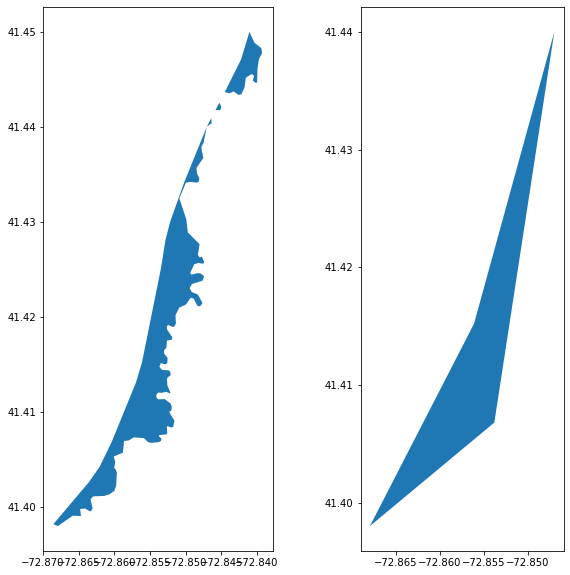

In [126]:
# Compare geometries in original and simplified dataset
n= 14318
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
dff[dff['MOL_ID']==n].geometry.plot(ax = ax1) 
sim3[sim3['MOL_ID']==n].geometry.plot(ax = ax2)

In [127]:
n= '310492'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
dff[dff['WDPA_PID']==n].geometry.plot(ax = ax1) 
sim3[sim3['WDPA_PID']==n].geometry.plot(ax = ax2)

/opt/anaconda3/envs/vizz38/lib/python3.8/site-packages/geopandas/plotting.py:399: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


<AxesSubplot:>

ValueError: cannot convert float NaN to integer

<Figure size 720x720 with 2 Axes>

<AxesSubplot:>

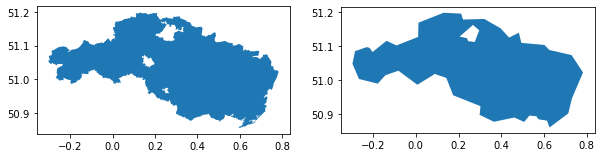

In [128]:
n = '20609'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
dff[dff['WDPA_PID']==n].geometry.plot(ax = ax1) 
sim3[sim3['WDPA_PID']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

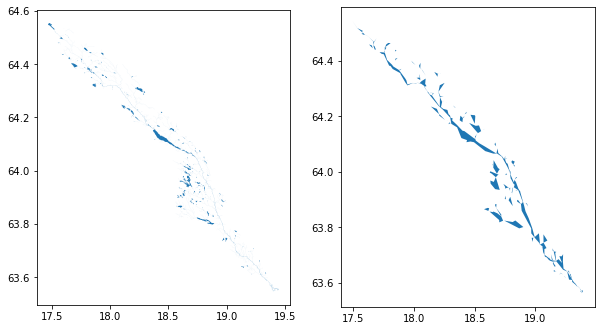

In [129]:
n = '555534655'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
dff[dff['WDPA_PID']==n].geometry.plot(ax = ax1) 
sim3[sim3['WDPA_PID']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

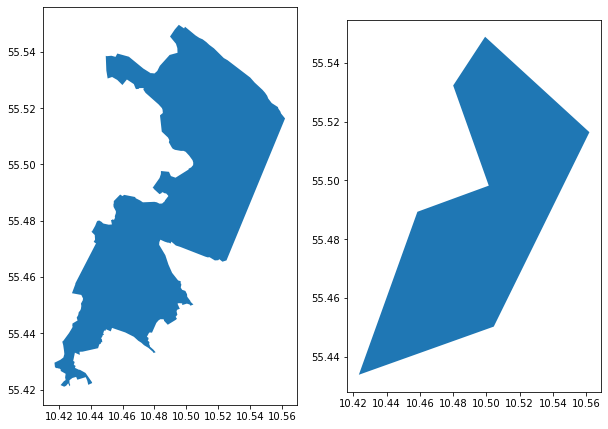

In [130]:
n = '555703244'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
dff[dff['WDPA_PID']==n].geometry.plot(ax = ax1) 
sim3[sim3['WDPA_PID']==n].geometry.plot(ax = ax2)

In [132]:
# Save file in local
sim3.to_file(f'{path}/Simplifications/WDPA_Ter_Simp99_nspecies.geojson', driver= 'GeoJSON')

In [134]:
sim1.to_file(f'{path}/Simplifications/WDPA_Terrestrial_Simplification50_nspecies.shp', driver= 'ESRI Shapefile')
sim2.to_file(f'{path}/Simplifications/WDPA_Terrestrial_Simplification90_nspecies.shp', driver= 'ESRI Shapefile')
sim3.to_file(f'{path}/Simplifications/WDPA_Terrestrial_Simplification99_nspecies.shp', driver= 'ESRI Shapefile')

---------------
## Marine WDPA (pending)

In [2]:
# # Create unzipped folder so mapshaper can bring the shp
# zipfile = '/Users/sofia/Documents/HE_Data/WDPA_FILTERED_20210615_FILTERED_all_with_oecm_wdpa_100mTol'
# unzipfile = ZipFile(f'{zipfile}.zip').extractall(zipfile)

In [ ]:
### Inspect file
# gdf = gpd.read_file(file_in)

In [2]:
# # Read file
# gdf = gpd.read_file('zip:///Users/sofia/Documents/HE_Data/WDPA_FILTERED_20210615_FILTERED_all_with_oecm_wdpa_100mTol.zip')
# len(gdf)

224133

In [3]:
# gdf[gdf['WDPA_PID']=='394131'] # reading csv keeps original characters as they are

,WDPAID,WDPA_PID,PA_DEF,NAME,ORIG_NA,DESIG,DESIG_E,DESIG_T,IUCN_CA,INT_CRI,...,ISO3,SUPP_IN,CONS_OB,SORTER,WDPA_PID_h,WDPA_PID__,hash_vl,AREA_KM,MOL_ID,geometry
177470,394131.0,394131,1,"""Fonds Gatot"" Et ""Laid Mâle""","""Fonds Gatot"" Et ""Laid Mâle""",Site Naturel D'Interêt Scientifique,Scientific Interest Site (Walloon Region),National,IV,Not Applicable,...,BEL,Not Applicable,Not Applicable,0.0,737c7794,-1628145044,-1628145044,0.100151,177471,"MULTIPOLYGON (((4.76254 50.57918, 4.75696 50.5..."


There are two WDPA that have weird geometries due to antimeridian: WDPA=220201 and WDPA= 555624810

These geometries need to be replaced by the correct ones (downloaded from protected planet)


In [6]:
# ## New geometries
# new1 = gpd.read_file('zip:///Users/sofia/Documents/HE_Data/WDPA_220201.zip')
# new2= gpd.read_file('zip:///Users/sofia/Documents/HE_Data/WDPA_555624810.zip')


<AxesSubplot:>

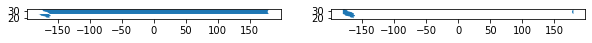

In [7]:
# ## See example
# n = 220201 
# fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
# gdf[gdf['WDPAID']==n].geometry.plot(ax = ax1) 
# new1[new1['WDPAID']==n].geometry.plot(ax = ax2)

In [8]:
# ## Get index for the geometry in gdf
# gdf['geometry'][gdf['WDPA_PID'] == '220201']

220579    MULTIPOLYGON (((-163.00000 25.38976, -163.0000...
Name: geometry, dtype: geometry

In [9]:
# ## Get index for geometry in new datasets
# new2['geometry'][new2['WDPA_PID'] == '555624810_E']

0    POLYGON ((-180.00000 -76.00000, -180.00000 -73...
Name: geometry, dtype: geometry

In [10]:
# ## Replace geometries with correct ones
# gdf.loc[220579, 'geometry']= new1.loc[[0], 'geometry'].values
# gdf.loc[207113, 'geometry']= new2.loc[[1], 'geometry'].values
# gdf.loc[222498, 'geometry']= new2.loc[[2], 'geometry'].values
# gdf.loc[222499, 'geometry']= new2.loc[[3], 'geometry'].values
# gdf.loc[222500, 'geometry']= new2.loc[[4], 'geometry'].values
# gdf.loc[222496, 'geometry']= new2.loc[[0], 'geometry'].values

In [11]:
# # Create subset with only relevant columns
# sub = gdf[['WDPAID','WDPA_PID','NAME','ORIG_NA','DESIG','DESIG_E','DESIG_T','IUCN_CA','MARINE','GOV_TYP','ISO3','OWN_TYP','AREA_KM','MOL_ID','geometry']]

In [13]:
# # Save file in local
# sub.to_file('/Users/sofia/Documents/HE_Data/WDPA_corrected', driver= 'ESRI Shapefile')